In [29]:
# ===============================
# 기본 라이브러리
# ===============================
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 머신러닝 관련
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 기준 모델 (해석 가능한 모델)
from sklearn.linear_model import LogisticRegression

# 성능 평가 지표
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    classification_report, confusion_matrix
)

# 고성능 트리 기반 모델
from xgboost import XGBClassifier


In [30]:
df = pd.read_csv(
    r"C:\ai\lecNote\1st_project\data\금리시장면적_고용지표수정_인허가일자머지_인구머지_폐업률추가.csv",
    low_memory=False
)

# 타겟: 3년 이내 폐업 여부 (0 = 유지, 1 = 폐업)
y = df["폐업_3년이내"]

In [31]:
# ===============================
# 타겟 클래스 분포 확인
# ===============================
class_counts = y.value_counts().sort_index()
class_ratio = y.value_counts(normalize=True).sort_index() * 100

print("📊 클래스 개수")
print(class_counts)

print("\n📊 클래스 비율 (%)")
print(class_ratio.round(2))

📊 클래스 개수
0    163485
1     73883
Name: 폐업_3년이내, dtype: int64

📊 클래스 비율 (%)
0    68.87
1    31.13
Name: 폐업_3년이내, dtype: float64


In [3]:
# ===============================
# 시설총규모 전처리 (㎡ → 평 → 구간화)
# ===============================

# 1㎡ = 0.3025평
df["시설총규모_평"] = df["시설총규모"] * 0.3025

# 평수 구간 정의
bins = [0, 10, 30, 50, 100, np.inf]
labels = [10, 30, 50, 100, 150]  # 구간별 대표값 (맥스값)

df["시설총규모"] = pd.cut(
    df["시설총규모_평"],
    bins=bins,
    labels=labels,
    right=True
).astype(float)

# 확인
df["시설총규모"].value_counts().sort_index()


10.0      86243
30.0     104903
50.0      25434
100.0     15424
150.0      5364
Name: 시설총규모, dtype: int64

In [4]:
# 수치형 변수
num_cols = [
    "base_rate",
    "시설총규모",
    "인허가일자_경제활동참가율",
    "인허가일자_실업률",
    "인허가일자_고용률",
    "구별인구",
    "창업월"
]

# 범주형 변수
cat_cols = [
    "업태_그룹",
    "구"
]

X = df[num_cols + cat_cols]


In [5]:
# 수치형 변수 + 타겟 결합
corr_df = pd.concat([X[num_cols], y], axis=1)

# 폐업 여부와의 상관계수 계산
corr = corr_df.corr()["폐업_3년이내"].drop("폐업_3년이내")

corr


base_rate       -0.002993
시설총규모           -0.115862
인허가일자_경제활동참가율   -0.006093
인허가일자_실업률        0.011267
인허가일자_고용률       -0.009593
구별인구             0.039054
창업월             -0.001239
Name: 폐업_3년이내, dtype: float64

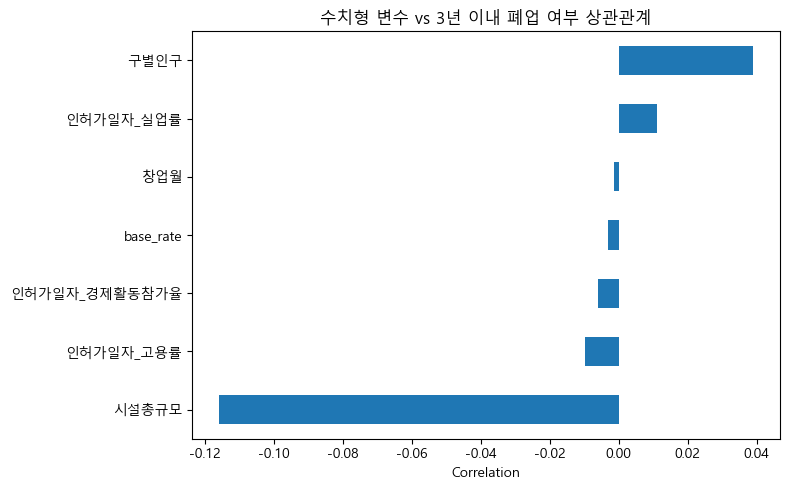

In [6]:
# 상관관계 시각화
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(8,5))
corr.sort_values().plot(kind="barh")
plt.title("수치형 변수 vs 3년 이내 폐업 여부 상관관계")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


In [7]:
from scipy.stats import chi2_contingency
import numpy as np

def chi2_report(table, var_name):
    chi2, p, dof, expected = chi2_contingency(table)

    n = table.values.sum()
    min_dim = min(table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))

    print(f"\n📊 [{var_name}] 카이제곱 독립성 검정 결과")
    print("-" * 50)
    print(f"Chi-square statistic (χ²): {chi2:.3f}")
    print(f"Degrees of freedom (df) : {dof}")
    print(f"P-value                : {p:.3e}")
    print(f"Sample size (n)        : {n}")
    print(f"Cramér’s V (효과크기)  : {cramers_v:.3f}")

    if p < 0.001:
        print("✅ 결과 해석: 통계적으로 매우 유의미한 관계 있음 (p < 0.001)")
    elif p < 0.05:
        print("⚠️ 결과 해석: 통계적으로 유의미한 관계 있음 (p < 0.05)")
    else:
        print("❌ 결과 해석: 통계적으로 유의미하지 않음")

    return chi2, p, dof, cramers_v


In [8]:
# 범주형 변수 검정 (카이제곱)
# 주형 변수는 상관계수를 쓸 수 없기 때문에, 카이제곱 검정을 통해 폐업 여부와의 통계적 연관성을 먼저 검증

from scipy.stats import chi2_contingency

# 업태별 폐업 여부
table_up = pd.crosstab(df["업태_그룹"], y)
chi2_up, p_up, dof_up, v_up = chi2_report(table_up, "업태_그룹")

# 구별 폐업 여부
table_gu = pd.crosstab(df["구"], y)
chi2_gu, p_gu, dof_gu, v_gu = chi2_report(table_gu, "구")




📊 [업태_그룹] 카이제곱 독립성 검정 결과
--------------------------------------------------
Chi-square statistic (χ²): 1235.540
Degrees of freedom (df) : 6
P-value                : 9.728e-264
Sample size (n)        : 237368
Cramér’s V (효과크기)  : 0.072
✅ 결과 해석: 통계적으로 매우 유의미한 관계 있음 (p < 0.001)

📊 [구] 카이제곱 독립성 검정 결과
--------------------------------------------------
Chi-square statistic (χ²): 1209.425
Degrees of freedom (df) : 24
P-value                : 2.402e-240
Sample size (n)        : 237368
Cramér’s V (효과크기)  : 0.071
✅ 결과 해석: 통계적으로 매우 유의미한 관계 있음 (p < 0.001)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [10]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [11]:
# 기준 모델: Logistic Regression

logit = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            solver="liblinear",
            class_weight="balanced",
            max_iter=1000
        ))
    ]
)

logit.fit(X_train, y_train)

proba_logit = logit.predict_proba(X_test)[:,1]
auc_logit = roc_auc_score(y_test, proba_logit)

auc_logit


0.5923604807215918

In [12]:
from sklearn.ensemble import RandomForestClassifier

# ===============================
# Random Forest
# ===============================
rf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, proba_rf)


In [13]:
xgb = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb.fit(X_train, y_train)

proba_xgb = xgb.predict_proba(X_test)[:,1]
auc_xgb = roc_auc_score(y_test, proba_xgb)

auc_xgb


0.6173720477671196

In [14]:
print(f"Logistic Regression AUC : {auc_logit:.3f}")
print(f"Random Forest AUC       : {auc_rf:.3f}")
print(f"XGBoost AUC             : {auc_xgb:.3f}")

Logistic Regression AUC : 0.592
Random Forest AUC       : 0.616
XGBoost AUC             : 0.617


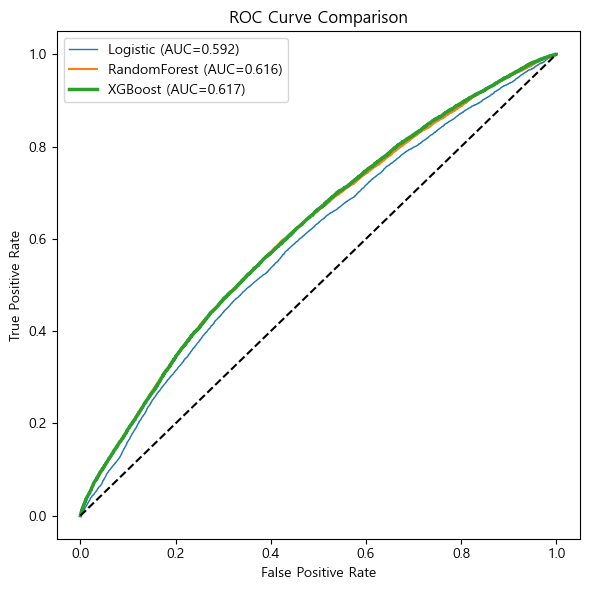

In [28]:
from sklearn.metrics import roc_curve

# ROC curve 계산
fpr_l, tpr_l, _ = roc_curve(y_test, proba_logit)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)
fpr_x, tpr_x, _ = roc_curve(y_test, proba_xgb)

plt.figure(figsize=(6,6))
plt.plot(fpr_l, tpr_l, label=f"Logistic (AUC={auc_logit:.3f})", linewidth=1)
plt.plot(fpr_r, tpr_r, label=f"RandomForest (AUC={auc_rf:.3f})", linewidth=1.5)
plt.plot(fpr_x, tpr_x, label=f"XGBoost (AUC={auc_xgb:.3f})", linewidth=2.5)


plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
pred_xgb = (proba_xgb >= 0.5).astype(int)

print(classification_report(y_test, pred_xgb))
print(confusion_matrix(y_test, pred_xgb))


              precision    recall  f1-score   support

           0       0.70      0.97      0.81     32697
           1       0.53      0.07      0.12     14777

    accuracy                           0.69     47474
   macro avg       0.62      0.52      0.47     47474
weighted avg       0.65      0.69      0.60     47474

[[31795   902]
 [13751  1026]]


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__max_depth": [4, 6],
    "model__learning_rate": [0.03, 0.05],
    "model__n_estimators": [300, 500],
    "model__subsample": [0.7, 0.8],
    "model__colsample_bytree": [0.7, 0.8]
}

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            scale_pos_weight=pos_weight,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['업태_그룹',
                                                                          '구']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['base_rate',
                                                                          '시설총규모',
                                                                          '인허가일자_경제활동참가율',
                                                                          '인허가일자_실업률',
                                                                          '인허가일자_고용률',
                                                                          '구별인구',
                                                                          '창업월'])])),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.7, 0.8],
                         'model__learning_rate': [0.03, 0.05],
                         'model__max_depth': [4, 6],
                         'model__n_estimators': [300, 500],
                         'model__subsample': [0.7, 0.8]},
             scoring='roc_auc', verbose=2)

In [18]:
grid.best_params_
grid.best_score_

0.617566580761795

In [19]:
best_model = grid.best_estimator_

proba_best = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, proba_best)


0.6186407589020851

In [20]:
print("Baseline XGB AUC :", auc_xgb)
print("GridSearch XGB AUC :", roc_auc_score(y_test, proba_best))


Baseline XGB AUC : 0.6173720477671196
GridSearch XGB AUC : 0.6186407589020851


In [21]:
best_model = grid.best_estimator_

In [22]:
proba_best = best_model.predict_proba(X_test)[:, 1]


In [23]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    preds = (proba_best >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"✅ Best Threshold (F1 기준): {best_t:.2f}")
print(f"✅ Best F1-score          : {best_f1:.3f}")


✅ Best Threshold (F1 기준): 0.42
✅ Best F1-score          : 0.489


In [32]:
from sklearn.metrics import classification_report
import pandas as pd

# threshold 적용 예측값 (이미 계산돼 있다면 이 줄은 생략)
pred_best = (proba_best >= best_t).astype(int)

# classification report → dict
report = classification_report(
    y_test,
    pred_best,
    output_dict=True
)

# 관심 있는 지표만 추출 (폐업 클래스 = 1)
metrics_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [
        report["1"]["precision"],
        report["1"]["recall"],
        report["1"]["f1-score"]
    ]
})

metrics_df


,Metric,Score
0,Precision,0.347674
1,Recall,0.825269
2,F1-score,0.489238


In [34]:
final_table = pd.DataFrame({
    "지표": ["Precision", "Recall", "F1-score"],
    "설명": [
        "폐업으로 예측한 것 중 실제 폐업 비율",
        "실제 폐업 중 모델이 찾아낸 비율",
        "Precision과 Recall의 조화 평균"
    ],
    "값 (폐업 클래스)": [
        report["1"]["precision"],
        report["1"]["recall"],
        report["1"]["f1-score"]
    ]
}).round(3)

final_table


,지표,설명,값 (폐업 클래스)
0,Precision,폐업으로 예측한 것 중 실제 폐업 비율,0.348
1,Recall,실제 폐업 중 모델이 찾아낸 비율,0.825
2,F1-score,Precision과 Recall의 조화 평균,0.489


In [24]:
import joblib

joblib.dump(
    {
        "model": best_model,   # GridSearch로 선택된 Pipeline 전체
        "threshold": best_t    # 최적 threshold
    },
    "final_xgb_closure_model.pkl"
)

print("✅ 모델 저장 완료: final_xgb_closure_model.pkl")


✅ 모델 저장 완료: final_xgb_closure_model.pkl


In [25]:
import joblib

saved = joblib.load("final_xgb_closure_model.pkl")

model = saved["model"]       # Pipeline (전처리 + XGB)
threshold = saved["threshold"]


In [26]:
user_input = {
    "base_rate": 3.5,
    "시설총규모": 10,  # ✅ 10 / 30 / 50 / 100 / 150 중 하나
    "인허가일자_경제활동참가율": 63.2,
    "인허가일자_실업률": 3.1,
    "인허가일자_고용률": 60.5,
    "구별인구": 320000,
    "창업월": 12,
    "업태_그룹": "카페",
    "구": "강남구"
}

df_user = pd.DataFrame([user_input])

In [27]:
# 폐업 확률 예측
proba = model.predict_proba(df_user)[0, 1]

# threshold 적용 → 최종 판단
pred = int(proba >= threshold)

print(f"📊 폐업 확률: {proba:.3f}")
print(f"📌 예측 결과: {'3년 이내 폐업 위험 있음' if pred == 1 else '폐업 위험 낮음'}")


📊 폐업 확률: 0.450
📌 예측 결과: 3년 이내 폐업 위험 있음
